In [2]:
%pip install xgboost 

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
# 将数据集进行时间因素和天气因素的合并
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/root/autodl-tmp/6.5_电力负荷预测/Electricity_Load_Forecast-main/data/Area1_Load_clean.csv')
# 只保留YMD，weekday，is_workday，Holiday_Info，Holiday_Name
df = df[['YMD', 'weekday', 'is_workday', 'Holiday_Info', 'Holiday_Name']]
df = df[(df['YMD'] >= '2012-01-01') & (df['YMD'] <= '2015-01-11')]
df.head()


,YMD,weekday,is_workday,Holiday_Info,Holiday_Name
1095,2012-01-01,6,0,10,New Year's Day
1096,2012-01-02,0,0,10,New Year's Day
1097,2012-01-03,1,0,10,New Year's Day
1098,2012-01-04,2,1,0,NaN
1099,2012-01-05,3,1,0,NaN


In [ ]:
df1 = pd.read_csv('/root/autodl-tmp/6.5_电力负荷预测/Electricity_Load_Forecast-main/data/Area1_Load_hour.csv')
df1['Time'] = pd.to_datetime(df1['Time'])
# 根据时间进行合并
# df1[]
df.head()

In [8]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import xgboost as xgb

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1) for the first column
    for i in range(n_in, 0, -1):
        cols.append(df.iloc[:, 0].shift(i))
    # forecast sequence (t, t+1, ... t+n) for the first column
    for i in range(0, n_out):
        cols.append(df.iloc[:, 0].shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # 添加剩余的列
    agg = concat([df.iloc[:, 1:], agg], axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


# load the dataset
series = read_csv('data/Area1_Weather_Load_copy.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=24)
print(data.shape)
# 输出第一个样本
print(data[0])


(26472, 30)
[  20.         13.         16.         59.          0.       3967.259968
 3563.567968 3283.864576 3101.586496 2972.481952 2872.967488 2825.230432
 2721.898528 2674.310752 2940.903712 3182.945824 3328.061152 3179.526496
 2905.11856  2820.243232 2820.690112 2944.5592   3173.022304 3635.882464
 3777.948928 3690.874336 3705.40864  3621.380512 3257.207776 2755.238848]


In [9]:
""" # 数据标准化standardize,使用标准差
def standardize_data(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    return (data - mean) / std

data = standardize_data(data) """

' # 数据标准化standardize,使用标准差\ndef standardize_data(data):\n    mean = data.mean(axis=0)\n    std = data.std(axis=0)\n    return (data - mean) / std\n\ndata = standardize_data(data) '

In [10]:
print(data[0])

[  20.         13.         16.         59.          0.       3967.259968
 3563.567968 3283.864576 3101.586496 2972.481952 2872.967488 2825.230432
 2721.898528 2674.310752 2940.903712 3182.945824 3328.061152 3179.526496
 2905.11856  2820.243232 2820.690112 2944.5592   3173.022304 3635.882464
 3777.948928 3690.874336 3705.40864  3621.380512 3257.207776 2755.238848]


(15884, 29) (15884,) (5294, 29) (5294,) (5294, 29) (5294,)
[0]	train-rmse:1873.65928	eval-rmse:1833.61469
[10]	train-rmse:827.07556	eval-rmse:823.51194
[20]	train-rmse:379.00928	eval-rmse:399.63613
[30]	train-rmse:190.81828	eval-rmse:234.98054
[40]	train-rmse:115.23751	eval-rmse:178.41711
[50]	train-rmse:85.60180	eval-rmse:159.81959
[60]	train-rmse:72.85536	eval-rmse:152.73028
[70]	train-rmse:65.57825	eval-rmse:149.23075
[80]	train-rmse:61.44996	eval-rmse:147.32116
[90]	train-rmse:58.32384	eval-rmse:145.89372
[100]	train-rmse:56.89028	eval-rmse:145.54628
[110]	train-rmse:55.66154	eval-rmse:145.19440
[120]	train-rmse:54.22063	eval-rmse:144.75438
[130]	train-rmse:52.73827	eval-rmse:144.25643
[140]	train-rmse:50.92416	eval-rmse:143.76964
[150]	train-rmse:49.50442	eval-rmse:143.53286
[160]	train-rmse:48.07181	eval-rmse:143.24623
[170]	train-rmse:46.62983	eval-rmse:142.92883
[180]	train-rmse:45.37670	eval-rmse:142.73071
[190]	train-rmse:43.96182	eval-rmse:142.47910
[200]	train-rmse:42.50994

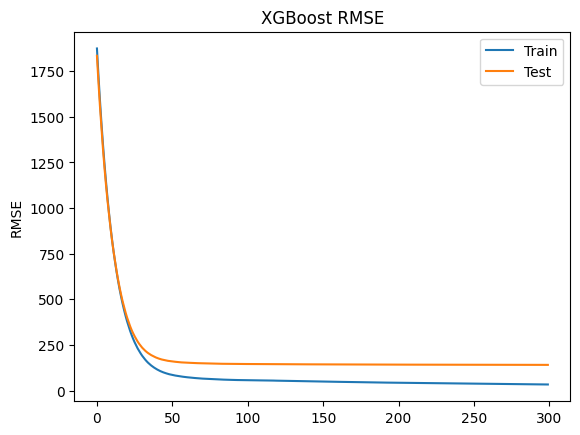

In [11]:
from math import sqrt
from sklearn.metrics import mean_squared_error

m_all = len(data) # 数据集总行数
m_val = int(0.2*m_all) # 验证集数量
m_test = int(0.2*m_all) # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量
# split into input and output columns
X_train,y_train = data[:m_train, :-1], data[:m_train, -1]
X_val,y_val = data[m_train:m_train+m_val, :-1], data[m_train:m_train+m_val, -1]
X_test,y_test = data[m_train+m_val:, :-1], data[m_train+m_val:, -1]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
# fit model
xgb_params = {
    'device':'cuda',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.082,
    'max_depth': 8,
    'seed': 2024,
    'nthread': -1,
    
    }
train_matrix = xgb.DMatrix(X_train , label=y_train)
valid_matrix = xgb.DMatrix(X_val , label=y_val)
test_matrix = xgb.DMatrix(X_test , label=y_test)

watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
evals_result = {}
reg = xgb.train(xgb_params, train_matrix, num_boost_round=300, evals=watchlist, early_stopping_rounds=50, verbose_eval=10, evals_result=evals_result)
val_pred  = reg.predict(valid_matrix)
test_pred = reg.predict(test_matrix)
""" reg = xgb.XGBRegressor(xgb_params,n_estimators=1000)
reg.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=False) """
# 画出loss曲线
from matplotlib import pyplot
results = evals_result
epochs = len(results['train']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['train']['rmse'], label='Train')
ax.plot(x_axis, results['eval']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()



In [12]:
xgb.plot_importance(reg)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

Test RMSE: 374.2968
Test MAPE: 2.41%


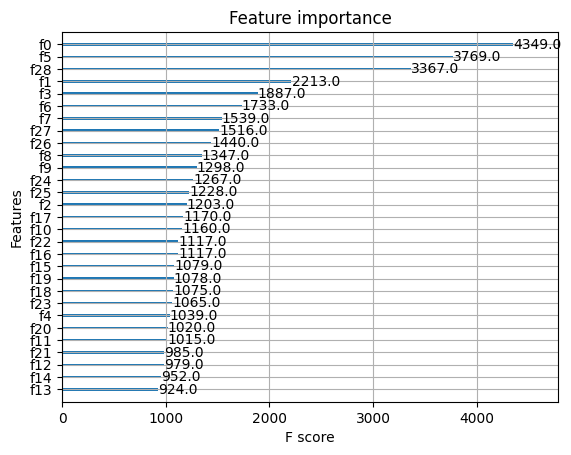

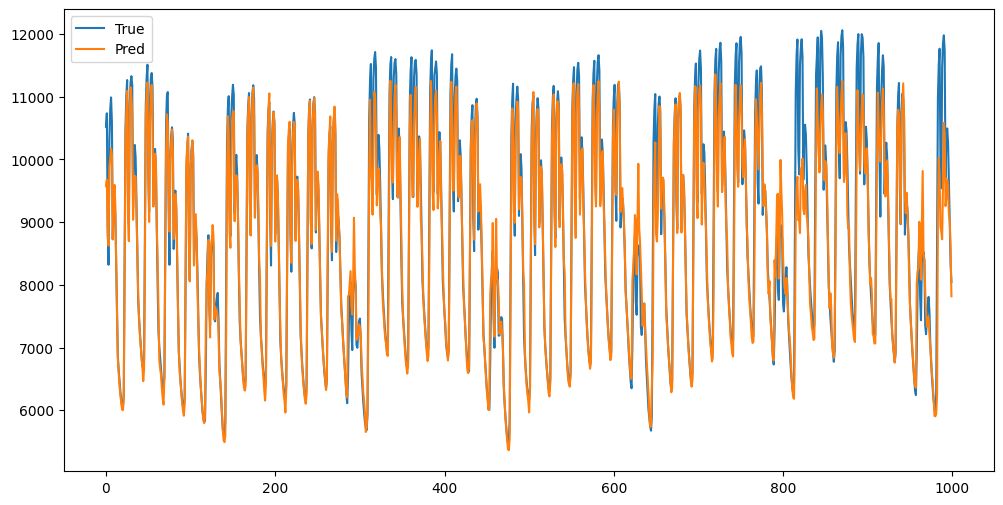

In [13]:
y_pred = test_pred
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse:.4f}')
# calculate MAPE
mape = 100 * (abs((y_test - y_pred) / y_test)).mean()
print(f'Test MAPE: {mape:.2f}%')
# 画出预测值和真实值的对比
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='True')
plt.plot(y_pred[:1000], label='Pred')
plt.legend()
plt.show()

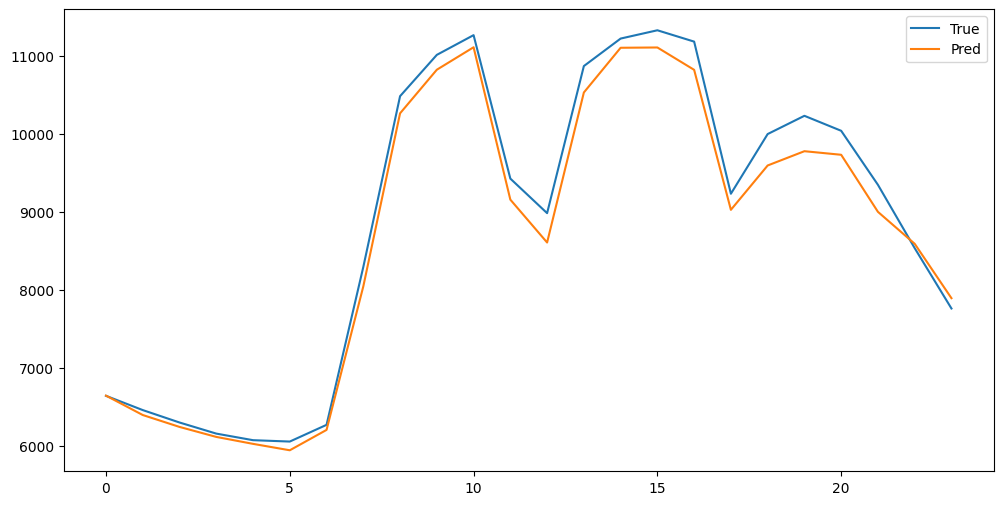

In [58]:
# 选出一天24小时的数据进行对比
plt.figure(figsize=(12, 6))
plt.plot(y_test[15:39], label='True')
plt.plot(y_pred[15:39], label='Pred')
plt.legend()
plt.show()